In [34]:

%pylab inline

import tensorflow as tf
%matplotlib inline
import numpy as np
from collections import deque
from os import listdir
import functools

pylab.rcParams['figure.figsize'] = (4.0, 4.0)

import pylab
from tsne import bh_sne
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import sklearn.manifold
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
import pyproj
import functools
import pickle 

image_width = 128

def display(image, min = 0.0, max = 1.0):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    




def display(image):
    plt.imshow(image, cmap = plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    
def memoize(obj, maxlen = 2000):
    """A decorator to cache advice objects using the advice key"""
    cache = obj.cache = {}
    deck = obj.deck = deque([], maxlen = maxlen)

    @functools.wraps(obj)
    def memoizer(*args, **kwargs):
        key = args[0]
        if key not in cache:
            if len(deck) == deck.maxlen:
              del cache[deck.popleft()[0]]
            temp = obj(*args, **kwargs)
            cache[key] = temp
            deck.append((key, temp))
        return cache[key]
        
    return memoizer

@memoize
def load_mat_from_file(key):
    f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/"+key+".npy","rb")
    return np.load(f)

@memoize
def get_file_containing(housex, housey):
#         print "house coords:", housex, housey
    for key in file_attributes:
        block = file_attributes[key]
    #         print block['xllcorner'], block['yllcorner']
        if block['xllcorner'] < housex < block['xllcorner'] + block['width']:
            if block['yllcorner'] < housey < block['yllcorner'] + block['height']:
                return key
    assert(1==0)

def imagex(housex, housey, block):
    return (int(housex)-block['xllcorner'])/5
def imagey(housex, housey, block):
    return (int(housey)-block['yllcorner'])/5



#housex and housey in meters
def get_heightmap_around(housex, housey, window_width_pixels = 28):
    
    def image_slice(key, housex, housey, radius = window_width_pixels/2):
        x = housex
        y = housey
        block = file_attributes[key]
        mat = load_mat_from_file(key)
        x1 = np.max([0,              imagex(x,y,block) - radius])
        x2 = np.min([block['ncols'], imagex(x,y,block) + radius])
        
        y1 = np.max([0,              imagey(x,y,block) - radius])
        y2 = np.min([block['nrows'], imagey(x,y,block) + radius])
        
        assert(x1 <= x2)
        assert(y1 <= y2)
        return  mat[block['nrows'] - y2:block['nrows'] - y1, x1:x2]
    
    window_width_feet = window_width_pixels * 5
    housex /= .3048 #convert to feet
    housey /= .3048
    x = housex
    y = housey
    ul = get_file_containing(x - window_width_feet/2, y - window_width_feet/2)
    ur = get_file_containing(x + window_width_feet/2, y - window_width_feet/2)
    ll = get_file_containing(x - window_width_feet/2, y + window_width_feet/2)
    lr = get_file_containing(x + window_width_feet/2, y + window_width_feet/2)

    for key in [ul, ur, ll, lr]:
        image = image_slice(key, x, y)
#         print image.shape
        if image.shape == (window_width_pixels, window_width_pixels):
            return image

    

    if ul == ur and lr == ll : # horizontal split


        result = np.zeros([window_width_pixels, window_width_pixels])
        upper_slice = image_slice(ul, housex, housey)
        lower_slice = image_slice(ll, housex, housey)
        
        result[:upper_slice.shape[0], :] = upper_slice
        result[ window_width_pixels - lower_slice.shape[0]:, :] = lower_slice


        return result
    elif ul == ll and ur == lr and ul != ur and ll != lr: # vertical split
        result = np.zeros([window_width_pixels, window_width_pixels])
        left_slice = image_slice(ll, housex, housey)
        right_slice = image_slice(ur, housex, housey)
#         print left_slice.shape
#         print right_slice.shape
        
        result[:, :left_slice.shape[1]] = left_slice
        result[:, window_width_pixels - right_slice.shape[1]:] = right_slice

#         plt.imshow(result)
#         plt.show()
#         display(result)

        return result
    else: # four way split
#         print "four way"
        ll_slice = image_slice(ll, housex, housey)
        ul_slice = image_slice(ul, housex, housey)
        lr_slice = image_slice(lr, housex, housey)
        ur_slice = image_slice(ur, housex, housey)
        
        result = np.zeros([window_width_pixels, window_width_pixels])
        result[:ll_slice.shape[0], :ll_slice.shape[1]] = ll_slice
        result[:lr_slice.shape[0], window_width_pixels - lr_slice.shape[1]:] = lr_slice
        
        result[window_width_pixels - ul_slice.shape[0]:, :ul_slice.shape[1]] = ul_slice
        result[window_width_pixels - ur_slice.shape[0]:, window_width_pixels - ur_slice.shape[1]:] = ur_slice
#         display(result)
        return result

        

def window_violated_chunk_borders(housex, housey):
    corners = [(housex-window_width_feet/2, housey-window_width_feet/2),
              (housex-window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey-window_width_feet/2)]
    files = map(lambda x: get_file_containing(x[0], x[1]), corners)
    return len(set(files)) > 1



file_attributes = {}

mypath = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files"
for filename in [f for f in listdir(mypath) if isfile(join(mypath, f))]: 
    attributes = {}
    with open(mypath + "/" + filename) as FileObj:
        for index, line in enumerate(FileObj):
            if(index < 6):
#                 print line
                attributes[line.split(" ")[0]] = int(line.split(" ")[-1][:-2])
            else:
                break # don't load the other lines into memory becuase that's a waste of time.

    attributes['width'] = attributes['ncols'] * attributes['cellsize']
    attributes['height'] = attributes['nrows'] * attributes['cellsize']
    file_attributes[filename] = attributes
print "loaded all file header attributes into dict"


def load_data(path, normalize_columns = False, only_columns_containing = ""):
    print("loading...")
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    data_dict = {}
    for label in set(df._get_numeric_data().columns).union({'hcad'}):
        # union hcad to ensure that hcad col comes in even if not considered numerical
        if normalize_columns and  label != 'hcad':
            column_data = df[label].astype(float)
            column_data -= np.min(column_data)
            data_dict[label] = column_data / np.max(column_data)
        else:
            data_dict[label] = df[label].astype(float)

        result = pandas.DataFrame.from_dict(data_dict)

    result = result.replace([np.inf, -np.inf], 1)
    
    result = result.sort(['hcad']).fillna(0)
    
    for label in result:
        if not only_columns_containing in str(label):
            result.drop([str(label)], axis = 1 , inplace= True)
    return result




def get_batch(batch_size = 100, random = True, start_index = 0, val = False):
    metamat = np.zeros([batch_size, image_width, image_width, 2]).astype(float32)
    metaY = np.zeros([batch_size,1]).astype(float32)
    extra_features = np.zeros([batch_size,len(wind_data[0])]).astype(float32)
    i = 0
    for _ in range(batch_size):

        index = i + start_index
        if random:
            index = rand.randint(0, len(meta)-1)
            if index % 100 == 0 and not val:
                index +=  rand.randint(1, 99)
                if index > len(meta):
                    index = len(meta) -1
            elif val:
                index -= index % 100
        lon = [meta['lon'][index]]
        lat = [meta['lat'][index]]
        max_wind_speed = np.max(wind_data[index])
        metaY[i] = y_gaussian[index] # y_data['y200_mean'][index]
        extra_features[i] = wind_data[index]

        xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
        housex=xx[0]
        housey=yy[0]

        lidar = None
        try:
            lidar = get_heightmap_around(housex, housey, window_width_pixels=image_width)
        except:
            continue
        if(lidar == None):
            continue
        
        lidar = lidar.copy()
        lidar[lidar < -100] = -100
        lidar[lidar >250] = 250
        lidar /= 250.0
#         lidar -= np.min(lidar)
#         lidar /= np.max(lidar)


        metamat[i, :, :, 0] = lidar

        wind_data_channel = np.zeros([image_width, image_width]).astype(float32)
        wind_data_channel.fill(max_wind_speed)
        metamat[i, :, :, 1] = wind_data_channel



        i += 1

    #metamat = metamat.reshape([batch_size, image_width**2])

    return metamat, extra_features, metaY

# X, _, _ = get_batch(100)
# plt.imshow(X[0,:,:,0])
# plt.show()
# X = X[:,:,:,0].reshape([-1])
# print np.min(X)
# plt.hist(X, bins = 50)
# plt.show()

Populating the interactive namespace from numpy and matplotlib
loaded all file header attributes into dict


`%matplotlib` prevents importing * from pylab and numpy


loading...
Opening /home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd in read-only mode
house lat lon [29.920000076293945] [-95.084800720214844]
[977962.9843141946] [4237588.749906508]


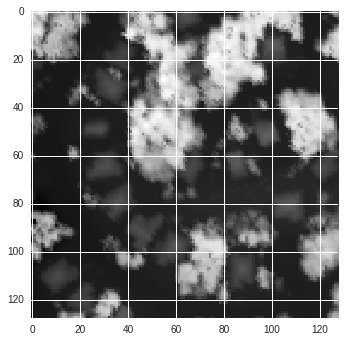

In [6]:



wind_data = np.array(
    load_data("/home/isaac/Dropbox/data_for_brian/wind_features/hcad_interp_withoutpartial_rad100_hist8x8.mat.hd", 
              normalize_columns=True, only_columns_containing = "spd")).astype(np.float32)
meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
y_data = load_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")
hcad_dpr = load_data("/home/isaac/Dropbox/data_for_brian/hcad_features/hcad_df_200.hd", 
              normalize_columns=True, only_columns_containing = "mean_dpr")
wind_data = np.concatenate((wind_data, hcad_dpr), axis = 1)
# wind_data = wind_data[meta['img0'] == 1]
# y_data = wind_data[meta['img0'] == 1]
y_gaussian = pickle.load(open( "/home/isaac/Desktop/house_guassian_damage_balance.p", "rb" ) )

wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum

# lon = [meta['lon'][250000]] #these are good becuase of clear local features
# lat = [meta['lat'][250000]]


lon = [meta['lon'][12000]]
lat = [meta['lat'][12000]]

print "house lat lon", lat, lon
xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
print xx, yy
housex=xx[0]
housey=yy[0]
display(get_heightmap_around(housex,housey, window_width_pixels = image_width))

n=10000



# metamat = metamat.astype(float32)
# metaY = np.zeros([len(meta)])



# for index in range(len(meta)):
    
# #     index = rand.randint(0, len(meta)-1)
#     lon = [meta['lon'][index]]
#     lat = [meta['lat'][index]]

#     xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
#     housex=xx[0]
#     housey=yy[0]
    
    
#     new_element = get_heightmap_around(housex, housey, window_width_pixels=image_width)
#     if(new_element == None):
#         print index
#         break
#     if index%1000 == 0:
#         print index
        
    
    
#     new_element = np.array([new_element])
#     metamat[index] = new_element
#     metamat[index] = metamat[index] - np.min(metamat[index])

#     metaY[index] = y_data['y'][index]

In [5]:
gc.collect() # collect garbage
data = pandas.read_hdf("/home/isaac/Dropbox/data_for_brian/y_df.hd", '/df')
df = pandas.DataFrame(data)
data_dict = {}
for label in set(df._get_numeric_data().columns).union({'hcad'}):
    # union hcad to ensure that hcad col comes in even if not considered numerical
    # if label != 'hcad':
    if normalize_columns:
        column_data = df[label].astype(float)
        column_data -= np.min(column_data)
        data_dict[label] = column_data / np.max(column_data)
    else:
        data_dict[label] = df[label].astype(float)

    result = pandas.DataFrame.from_dict(data_dict)

result = result.replace([np.inf, -np.inf], 1)

result = result.sort(['hcad']).fillna(0)

NameError: name 'gc' is not defined

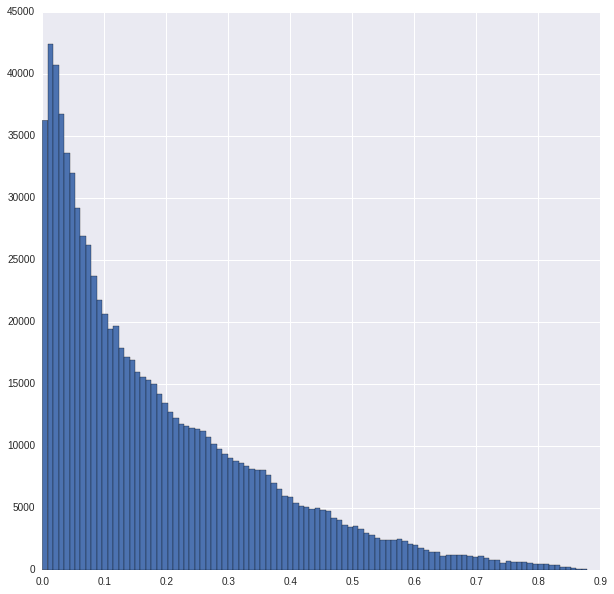

In [13]:
plt.hist(y_gaussian, bins = 100)
plt.show()

In [30]:
import tflearn
tf.reset_default_graph()
# Data loading and preprocessing
# image_data_data, extra_features_data, batch_y = get_batch(batch_size=13640, random = True)
image_data_data, _, batch_y = get_batch(batch_size=160, random = True)
# print batch_y[0]
# np.random.shuffle(batch_y)
# print batch_y[0]
# batch_y = np.round(batch_y)
# for i in range(len(batch_y)):
#     extra_features_data[i].fill(batch_y[i][0])

image_data = tf.placeholder(tf.float32, [None, image_width, image_width, 2], name = 'image_data_placeholder')
extra_features = tf.placeholder(tf.float32, [None, len(wind_data[0])], name = 'extrafeatures_ph')
# extra_features = tf.placeholder(tf.float32, [None, 1], name = 'extrafeatures_ph')

y = tf.placeholder(tf.float32, [None,1], name = 'y_placeholder')

# X, Y = image_data_data, batch_y
# print X.shape
# Building deep neural network
# network = tflearn.input_data(shape=[None, image_width, image_width, 2])
# print network.get_shape()

## Define the compressive stage
print image_data.get_shape(), "<- image input"

network = tflearn.conv_2d(image_data, 32, 11, strides=4, activation='relu', regularizer="L2", weight_decay=0.0)
print network.get_shape()
network = tflearn.layers.conv.max_pool_2d (network, 2, strides=2, padding='same', name='MaxPool2D')
print network.get_shape()
network = tflearn.conv_2d(network, 128, 5,  strides=1, activation='relu', regularizer="L2", weight_decay=0.0)
print network.get_shape()
netowrk = tflearn.layers.core.dropout (network, .7, name='Dropout')

network = tflearn.layers.conv.max_pool_2d (network, 2, strides=2, padding='same', name='MaxPool2D')
print network.get_shape()

network = tflearn.conv_2d(network, 128, 3,  strides=1, activation='relu', regularizer="L2", weight_decay=0.0)
print network.get_shape()
netowrk = tflearn.layers.core.dropout (network, .7, name='Dropout')

network = tflearn.conv_2d(network, 64, 3, activation='relu', regularizer="L2", weight_decay=0.0)

# network = tflearn.layers.conv.max_pool_2d (network, 2, strides=2, padding='same', name='MaxPool2D')
# print network.get_shape()

# middle = tflearn.conv_2d(network, 32, 9,  strides=2, activation='relu', regularizer="L2", weight_decay=0.0)

middle = network

print middle.get_shape(), "<- middle"


## Reconstruct the input
network = tflearn.conv_2d_transpose(middle, 32, 5, [16, 16, 32], strides=2, activation='relu', regularizer="L2", weight_decay=0.0)
print network.get_shape()
network = tflearn.layers.conv.upsample_2d (network, 2)
print network.get_shape()

network = tflearn.conv_2d_transpose(network, 32, 5, [64, 64, 32], strides=2, activation='relu', regularizer="L2", weight_decay=0.0)
print network.get_shape()
# network = tflearn.layers.conv.upsample_2d (network, 2)
print network.get_shape()
AE_output = tflearn.conv_2d_transpose(network, 2, 5, [image_width, image_width, 2], strides=2, activation='tanh', regularizer="L2", weight_decay=0.0)
print AE_output.get_shape()


## predict damage
dense1 = tflearn.fully_connected(middle, 460, activation='relu',
                                 regularizer='L2', weight_decay=0.0)
print "pre merge", dense1.get_shape()
dense2 = tflearn.layers.merge_ops.merge ([dense1, extra_features], 'concat', axis = 1, name='MergeOutputs')
print "post merge", dense2.get_shape()

dense3 = tflearn.fully_connected(dense2, 130, activation='relu',
                                 regularizer='L2', weight_decay=0.0)

y_pred = tflearn.fully_connected(dense3, 1, activation='sigmoid',
                                 regularizer='L2', weight_decay=0.0)

# Define loss and optimizer
alpha = .8
y_loss = tf.reduce_mean(tf.square(tf.sub(y_pred, y))) 
autoencoder_loss = tf.reduce_mean(tf.square(tf.sub(image_data, AE_output)) )
cost = (alpha *y_loss ) + ((1-alpha) * autoencoder_loss)

optimizer = tf.train.RMSPropOptimizer(learning_rate=.002).minimize(cost)

y_optimizer = tf.train.RMSPropOptimizer(learning_rate=.002).minimize(y_loss)

# dense2 = tflearn.fully_connected(dense1, 164, activation='relu',
#                                  regularizer='L2', weight_decay=0.0)
# network = tflearn.fully_connected(network, 1, activation='tanh')

# # Regression using SGD with learning rate decay and Top-3 accuracy


init = tf.initialize_all_variables()
# Launch the graph
sess = tf.Session()
sess.run(init)





# sgd = tflearn.RMSProp(learning_rate=0.001)
# net = tflearn.regression(network, optimizer=sgd,
#                          loss='mean_square')

# # Training
# model = tflearn.DNN(net, tensorboard_verbose=0)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:256: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(?, 128, 128, 2) <- image input
(?, 32, 32, 32)
(?, 16, 16, 32)
(?, 16, 16, 128)
(?, 8, 8, 128)
(?, 8, 8, 128)
(?, 8, 8, 64) <- middle
(?, 16, 16, 32)
(?, 32, 32, 32)
(?, 64, 64, 32)
(?, 64, 64, 32)
(?, 128, 128, 2)
pre merge (?, 460)
post merge (?, 472)


In [37]:
y_average = np.mean(y_gaussian)
    


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:258: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


mean MSE for first 400 samples: 0.0354499341698


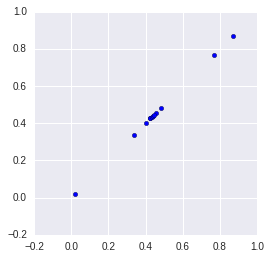

image shape: (400, 128, 128, 2)


In [ ]:
batch_size = 200
step = 1
image_data_data, extra_features_data, batch_y = get_batch(batch_size=400, random = False, start_index = 10000)

print "mean MSE for first 400 samples:", np.mean(np.square(np.array([y_average]*len(y_list)) - y_list))

#print "batch_y:", batch_y
plt.scatter(extra_features_data[0], extra_features_data[1])
plt.show()

def show_image(image_mat, index):
    print np.min(image_mat[index,:,:,0]),np.max(image_mat[index,:,:,0])

    plt.imshow(image_mat[index,:,:,0])
    plt.show()

    
# show_image(image_data_data, 0)
# show_image(image_data_data, 1)
# show_image(image_data_data, 2)
# show_image(image_data_data, 3)



# step = 0
print "image shape:", image_data_data.shape
while step * batch_size < 10000000000:
    image_data_data, extra_features_data, batch_y = get_batch(batch_size=60, random = True, start_index = 0)


    sess.run(optimizer, feed_dict={image_data: image_data_data,
                                   extra_features: extra_features_data,
                                   y: batch_y})
    if  step % 5000 == 0:
        
        print "mean MSE:", np.mean(np.square(np.array([y_average]*len(batch_y)) - batch_y))

        # Calculate batch loss and accuracy
        y_guess, y_loss_fetched, autoencoder_loss_fetched, joint_loss = sess.run([y_pred, y_loss, autoencoder_loss, cost], 
                                              feed_dict={image_data: image_data_data,
                                                          extra_features: extra_features_data,
                                                          y: batch_y})
        print ("Iter " + str(step*batch_size) + ", Minibatch Y Loss= ", 
            str(y_loss_fetched), "Joint cost:", str(joint_loss),
               "Autoencoder cost:", str(autoencoder_loss_fetched))
        plt.scatter(y_list, y_guess)
        plt.show()

    step += 1
print "Optimization Finished!"

In [33]:
print len(meta)

870476


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:256: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


mean MSE: 0.0284962


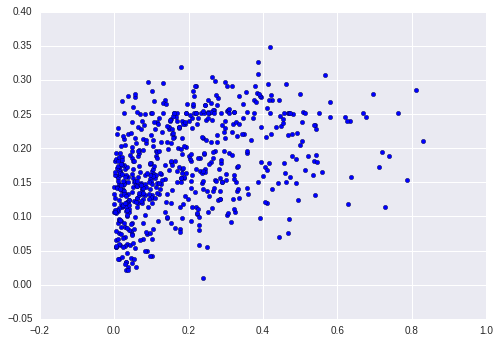

In [27]:
image_data_data, extra_features_data, batch_y = get_batch(batch_size=600, random = True, val = False)
y_list = batch_y.reshape([-1])

print "mean MSE:", np.mean(np.square(np.array([np.mean(y_list)]*len(y_list)) - y_list))
prediction = sess.run(y_pred, feed_dict={image_data: image_data_data,
                                   extra_features: extra_features_data,
                                   y: batch_y})
plt.scatter(y_list, prediction)

In [ ]:
y_predicted = []
for i in range(0,len(wind_data), batch_size):
    image_data_data, extra_features_data, batch_y = get_batch(batch_size=batch_size, random = False, start_index = i)
    y_predicted.extend([x[0] for x in sess.run(pred, feed_dict={image_data: image_data_data,
                                   extra_features: extra_features_data,
                                   y: batch_y,
                                   keep_prob: 1.0})])


    

In [15]:
import tflearn
tf.reset_default_graph()
# Data loading and preprocessing
# image_data_data, extra_features_data, batch_y = get_batch(batch_size=13640, random = True)
image_data_data_val, _, batch_y_val = get_batch(batch_size=160, random = True)
# print batch_y[0]
# np.random.shuffle(batch_y)
# print batch_y[0]
# batch_y = np.round(batch_y)
# for i in range(len(batch_y)):
#     extra_features_data[i].fill(batch_y[i][0])

# X, Y = image_data_data, batch_y
# print X.shape
# Building deep neural network
network = tflearn.input_data(shape=[None, image_width, image_width, 2])
network = tflearn.conv_2d(network, 32, 3, strides=1, activation='relu', regularizer="L2")
network = tflearn.layers.conv.max_pool_2d (network, 2, strides=None, padding='same', name='MaxPool2D')
network = tflearn.conv_2d(network, 32, 5,  strides=1, activation='relu', regularizer="L2")
network = tflearn.layers.conv.max_pool_2d (network, 2, strides=None, padding='same', name='MaxPool2D')
network = tflearn.conv_2d(network, 32, 5, strides=1, activation='relu', regularizer="L2")
# network = tflearn.layers.conv.max_pool_2d (network, 2, strides=None, padding='same', name='MaxPool2D')
network = tflearn.conv_2d(network, 32, 5, strides=2, activation='relu', regularizer="L2")
# network = tflearn.layers.conv.max_pool_2d (network, 2, strides=None, padding='same', name='MaxPool2D')
# network = tflearn.conv_2d(network, 32, 5, strides=2, activation='relu', regularizer="L2")
# network = tflearn.fully_connected(network, 100, activation='tanh')
# network = tflearn.fully_connected(network, 100, activation='tanh')


# dense1 = tflearn.fully_connected(input_layer, 164, activation='relu',
#                                  regularizer='L2', weight_decay=0.0)
# dense2 = tflearn.fully_connected(dense1, 164, activation='relu',
#                                  regularizer='L2', weight_decay=0.0)
network = tflearn.fully_connected(network, 1, activation='tanh')

# Regression using SGD with learning rate decay and Top-3 accuracy
sgd = tflearn.RMSProp(learning_rate=0.001)
net = tflearn.regression(network, optimizer=sgd,
                         loss='mean_square')

# Training
model = tflearn.DNN(net, tensorboard_verbose=0)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:251: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [ ]:
for _ in range(10000):
    X, extra_features_data, Y = get_batch(batch_size= 15000, random = False)
    model.fit(X, Y, n_epoch=1000, 
              show_metric=True, run_id="dense_model", batch_size=None, shuffle=None, snapshot_epoch=False)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:252: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [ ]:
# while True:
image_data_data, _, batch_y = get_batch(batch_size=1060, random = True)

X, Y = image_data_data, batch_y

model.fit(X, X, n_epoch=5, 
          show_metric=True, run_id="dense_model", batch_size=None, shuffle=None, snapshot_epoch=False)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:251: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


-0.0322201065719 0.351446837187


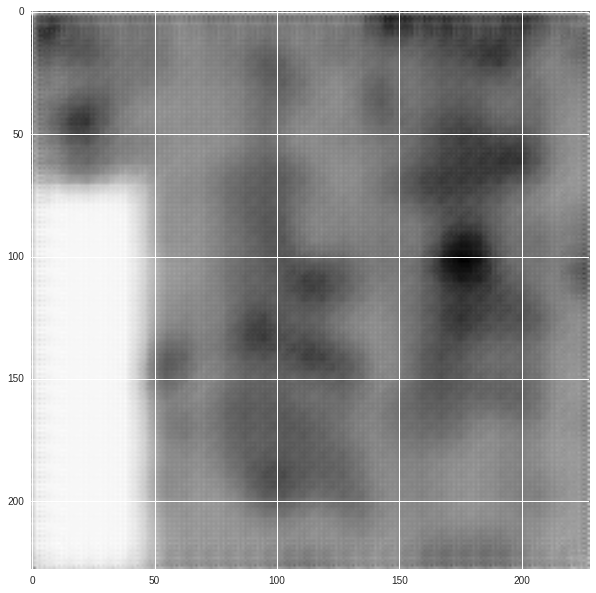

0.000687122 0.477539


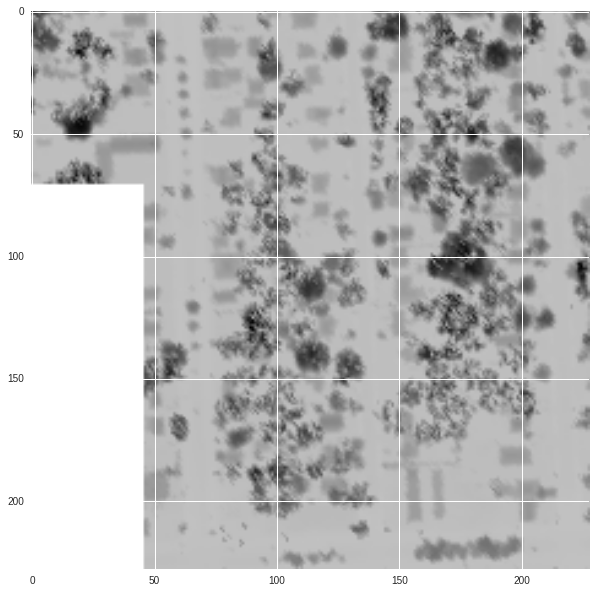

In [173]:

# X, _, Y = get_batch(batch_size=3)
p_y = model.predict(X[:3])
plt.imshow(np.array(p_y)[0,:,:,0])
print np.min(np.array(p_y)[0,:,:,0]),  np.max(np.array(p_y)[0,:,:,0])

plt.show()
plt.imshow(X[0,:,:,0])
print np.min(np.array(X)[0,:,:,0]),  np.max(np.array(X)[0,:,:,0])

plt.show()


In [7]:
print network

Tensor("FullyConnected/Tanh:0", shape=(?, 1), dtype=float32)


In [48]:
old = image_data_data, extra_features_data, batch_y


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


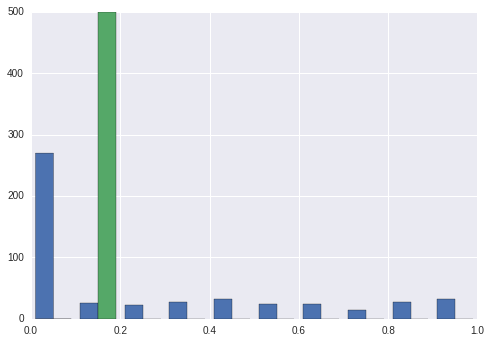

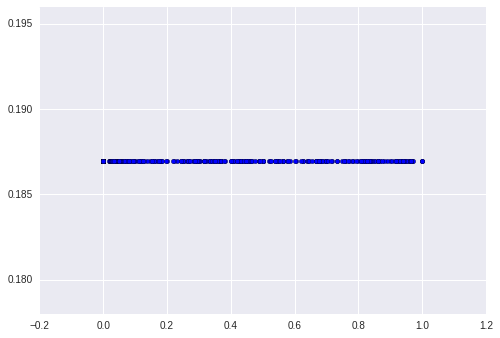

In [24]:
image_data_data, extra_features_data, batch_y = get_batch(batch_size=500, random = False)

prediction = model.predict(image_data_data)



plt.hist([batch_y, prediction])
plt.show()
plt.scatter(batch_y,prediction)
plt.show()

In [ ]:

""" AlexNet.
Applying 'Alexnet' to Oxford's 17 Category Flower Dataset classification task.
References:
    - Alex Krizhevsky, Ilya Sutskever & Geoffrey E. Hinton. ImageNet
    Classification with Deep Convolutional Neural Networks. NIPS, 2012.
    - 17 Category Flower Dataset. Maria-Elena Nilsback and Andrew Zisserman.
Links:
    - [AlexNet Paper](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
    - [Flower Dataset (17)](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/)
"""

from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

import tflearn.datasets.oxflower17 as oxflower17
tf.reset_default_graph()

# X, Y = oxflower17.load_data(one_hot=True, resize_pics=(227, 227))
X, extra_features_data, Y = get_batch(batch_size= 15000, random = False)
# Building 'AlexNet'
network = input_data(shape=[None, image_width, image_width, 2])
network = conv_2d(network, 96, 11, strides=4, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 256, 5, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 384, 3, activation='relu')
network = conv_2d(network, 256, 3, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
network = fully_connected(network, 400, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 400, activation='tanh')
network = dropout(network, 0.5)
network = fully_connected(network, 1, activation='sigmoid')
network = regression(network, optimizer='momentum',
                     loss='mean_square',
                     learning_rate=0.001)

# Training
model = tflearn.DNN(network, checkpoint_path='model_alexnet',
                    max_checkpoints=1, tensorboard_verbose=2)


In [7]:
model.fit(X, Y, n_epoch=1000, validation_set=0.1, shuffle=True,
          show_metric=True, batch_size=164, snapshot_step=200,
          snapshot_epoch=False, run_id='alexnet_oxflowers17')

Training Step: 31204  | total loss: 0.00158
| Momentum | epoch: 097 | loss: 0.00158 - acc: 1.0000 -- iter: 06724/13500


KeyboardInterrupt: 

In [ ]:
colors = np.zeros([len(batch_y), 3])
colors[:,0] = batch_y[:,0]
colors[:,1] = batch_y[:,0]
colors[:,2] = batch_y[:,0]



plt.plot(extra_features_data)
plt.show()
plt.scatter(batch_y, extra_features_data[:,1])
plt.show()
plt.scatter(batch_y, extra_features_data[:,-1])
plt.show()
plt.scatter(extra_features_data[:,1], extra_features_data[:,-1], c=batch_y[:,0])
plt.show()

In [ ]:


'''
A Convolutional Network implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

import tensorflow as tf


# Parameters
learning_rate = 0.01
training_iters = 200000
batch_size = 5
display_step = 10

# Network Parameters
n_input = image_width**2 # MNIST data input (img shape: 28*28)
n_classes = 1 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
image_data = tf.placeholder(tf.float32, [None, image_width, image_width, 2], name = 'image_data_placeholder')
extra_features = tf.placeholder(tf.float32, [None, len(wind_data[0])], name = 'extrafeatures_ph')
# extra_features = tf.placeholder(tf.float32, [None, 1], name = 'extrafeatures_ph')

y = tf.placeholder(tf.float32, [None,1], name = 'y_placeholder')
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)


def stack(input_mat, num_neurons, nonlinearity):
    weights = tf.Variable(tf.random_normal([int(input_mat.get_shape()[1]), num_neurons], stddev=0.35))
   # weight_variables.append(weights)
    biases = tf.Variable(tf.random_normal([num_neurons], stddev=0.35))
    return nonlinearity(tf.add(tf.matmul(input_mat, weights), biases))

# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, image_width, image_width, 2])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print "conv2 shape", conv2.get_shape()
    
    
    conv3 = conv2d(conv2, tf.random_normal([5, 5, 16, 16]), tf.random_normal([16]))
    conv3 = maxpool2d(conv3, k=2)
    conv4 = conv2d(conv3, tf.random_normal([5, 5, 16, 16]), tf.random_normal([16]))
    conv4 = maxpool2d(conv4, k=2)
    print "conv4 shape", conv4.get_shape()

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv4, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    print "fc1 shape", fc1.get_shape()
    # Output, class prediction
    out = (tf.add(tf.matmul(fc1, weights['out']), biases['out']))
    return out

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 2, 16])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 16, 16])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([8*8*16, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([16])),
    'bc2': tf.Variable(tf.random_normal([16])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model


conv_net_out = conv_net(image_data, weights, biases, keep_prob)


# pred = tf.concat(1, [stack(conv_net_out, 40, tf.nn.relu), 
#                            stack(stack(extra_features, 40, tf.nn.relu),40,tf.nn.relu)])
pred = stack(extra_features, 120, tf.nn.sigmoid)
# pred = stack(conv_net_out, 40, tf.nn.relu)
pred =  stack(pred,100,tf.nn.sigmoid)
pred =  stack(pred,1,tf.nn.sigmoid)

# Define loss and optimizer
cost = tf.reduce_mean(tf.square(tf.sub(pred, y)) )
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables

# Keep training until reach max iterations


#     print "Testing Accuracy:", \
#         sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
#                                       y: mnist.test.labels[:256],
#                                       keep_prob: 1.})
init = tf.initialize_all_variables()
# Launch the graph
sess = tf.Session()
sess.run(init)

step = 1
while step * batch_size < training_iters:
    image_data_data, extra_features_data, batch_y = get_batch(batch_size=batch_size, random = False)

    sess.run(optimizer, feed_dict={image_data: image_data_data,
                                   extra_features: extra_features_data,
                                   y: batch_y,
                                   keep_prob: 1.})
    if step % max(display_step, 500) == 0:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([cost, accuracy], feed_dict={image_data: image_data_data,
                                                          extra_features: extra_features_data,
                                                          y: batch_y,
                                                          keep_prob: 1.})
        print "Iter " + str(step*batch_size) + ", Minibatch Loss= ", loss #+ ", Training Accuracy= " #+ \
              #"{:.5f}".format(acc)
        #print "y avg", np.mean(batch_y[:,0])
    step += 1
print "Optimization Finished!"

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


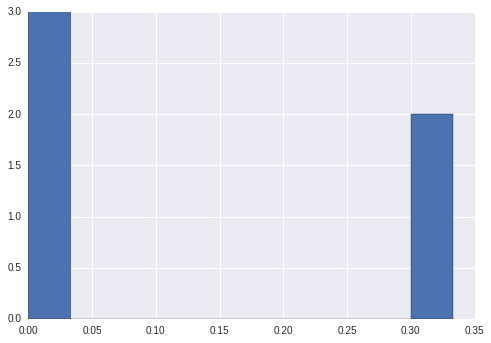

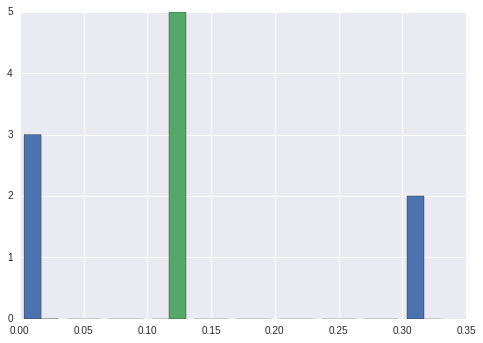

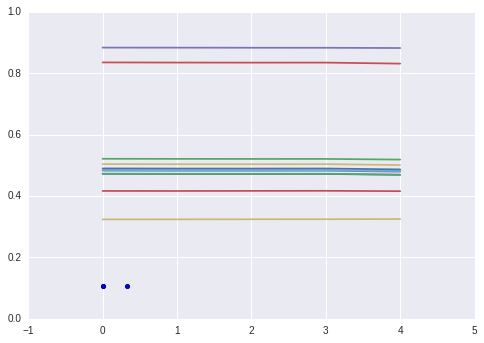

1.0
0.0
0.883689
0.323908
11


In [20]:
image_data_data, extra_features_data, batch_y = get_batch(batch_size=batch_size, random = False)
y_predicted = sess.run(pred, feed_dict={image_data: image_data_data,
                                   extra_features: extra_features_data,
                                   y: batch_y,
                                   keep_prob: dropout})

plt.hist(batch_y)
plt.show()
plt.hist([batch_y, y_predicted])
# plt.hist(y_predicted)
plt.show()

plt.scatter(batch_y, y_predicted)

# for i in range(len(extra_features_data[0])):
#     plt.scatter(batch_y, extra_features_data[:,i])
#     plt.show()
plt.plot(extra_features_data)
plt.show()


# plt.hist(np.max(get_batch(batch_size=batch_size)[1], axis = 1))
# plt.show()

print np.max(image_data_data)
print np.min(image_data_data)
print np.max(extra_features_data[0])
print np.min(extra_features_data)
print len(extra_features_data[0])
